# Exploration Notebook for Louvain (UCI-ID 186, Wine Quality)

## Imports

In [1]:

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sb
import umap.plot
from community import community_louvain
from ucimlrepo import fetch_ucirepo

D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\numba\np\ufunc\dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, erro

In [3]:
import sys

sys.path.append("../")
import visualization
import processing
from embedding_obj import EmbeddingObj

## Data Preparation

In [4]:
# fetch dataset (available at https://archive.ics.uci.edu/dataset/186/wine+quality)
image_segmentation = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets, dtype="float32")

target_feature = "pH"
labels = pd.Categorical(y["quality"]).codes

X.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_1352\3607462673.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


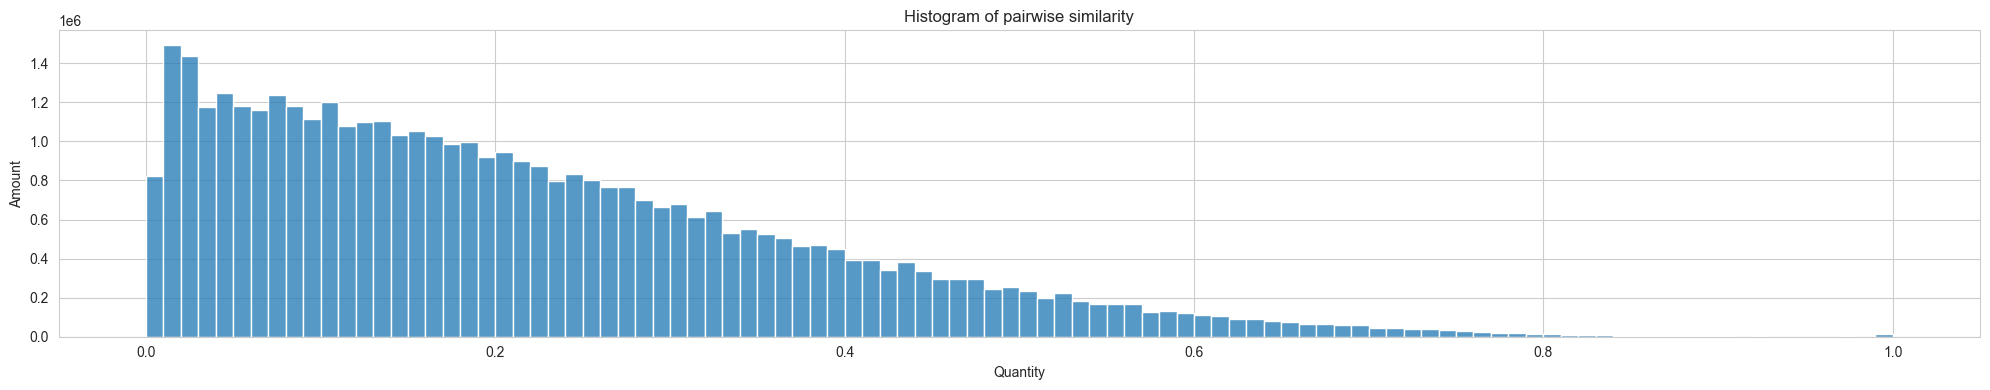

In [5]:
connectivity_pairwise = processing.compute_pairwise_dist(X, [target_feature])

fig, ax = plt.subplots(figsize=(20, 4))
sb.histplot(connectivity_pairwise.flatten(), bins=100, ax=ax)
ax.set_title("Histogram of pairwise similarity")
ax.set_xlabel("Quantity")
ax.set_ylabel("Amount")

fig.tight_layout()
fig.show()

## Compute initial UMAP-Embedding & Louvain Partition

In [6]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_
connectivity_umap_knn = umap_mapper.graph_

D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Software-Projekte\Uni\modDR\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [7]:
graph_umap_knn = nx.Graph(connectivity_umap_knn)
edge_weights_umap_knn = [
    graph_umap_knn[u][v]["weight"] for u, v in graph_umap_knn.edges()
]

graph_knn_feat, edge_weights_knn_feat = processing.compute_graph_weights(X, [
    target_feature], n_neighbors=5)

knn_list = [
    EmbeddingObj(graph=graph_umap_knn,
                 embedding={i: coords for i, coords in enumerate(umap_embedding)},
                 edge_weights=edge_weights_umap_knn,
                 title="UMAP-Positions with UMAP-kNN"),
    EmbeddingObj(graph=graph_knn_feat,
                 embedding={i: coords for i, coords in enumerate(umap_embedding)},
                 edge_weights=edge_weights_knn_feat,
                 title=f"UMAP-Positions with kNN for Similarity of '{target_feature}'")
]

for embedding_obj in knn_list:
    embedding_obj.com_partition = community_louvain.best_partition(
        embedding_obj.sim_graph, random_state=0)

    embedding_obj.labels = embedding_obj.com_partition

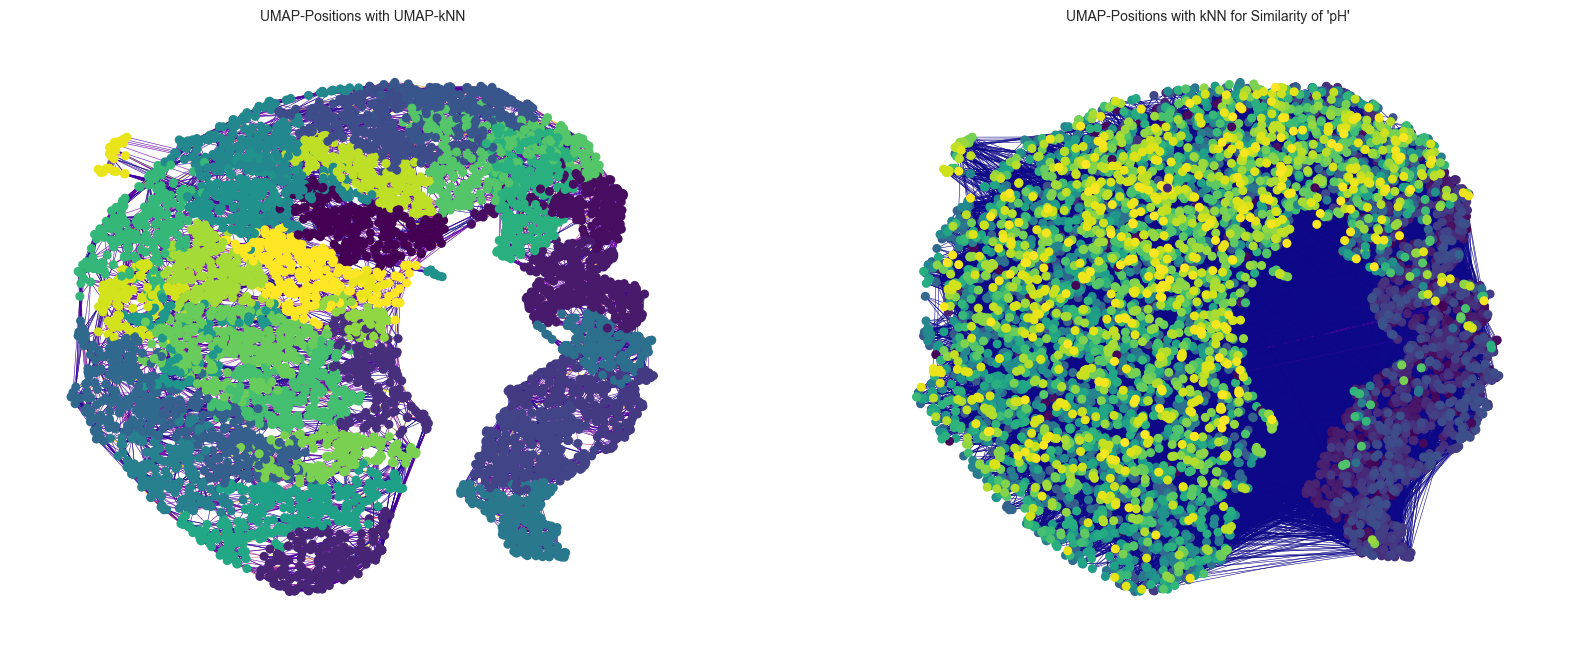

In [8]:
visualization.display_graphs(knn_list,
                             figsize_columns=2,
                             figsize=(20, 8),
                             cmap='viridis',
                             show_cbar=False)

In [9]:
connectivity_umap_knn_nx = nx.Graph(connectivity_umap_knn)

for u, v in connectivity_umap_knn_nx.edges():
    connectivity_umap_knn_nx[u][v]["weight"] = connectivity_pairwise[u][v]

## Visualize embeddings

### 2.1 No MST, no threshold

In [10]:
embeddings, partition_dict = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    [1, 20, 50, 100])

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


In [11]:
# partition_values = embeddings[0].labels
partition_values = set(partition_dict.values())

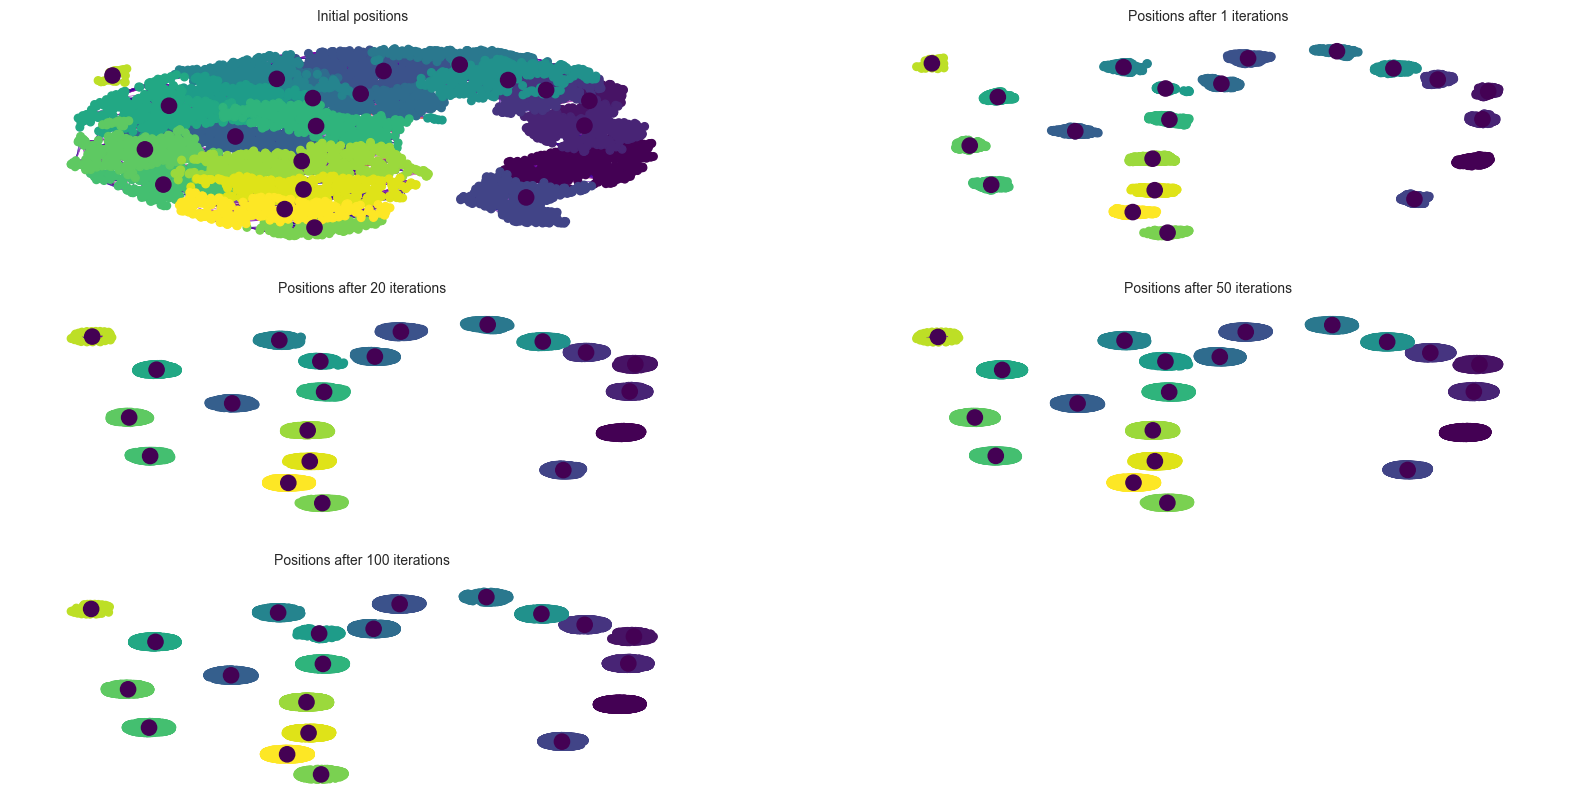

In [12]:
visualization.display_graphs(embeddings,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             # cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

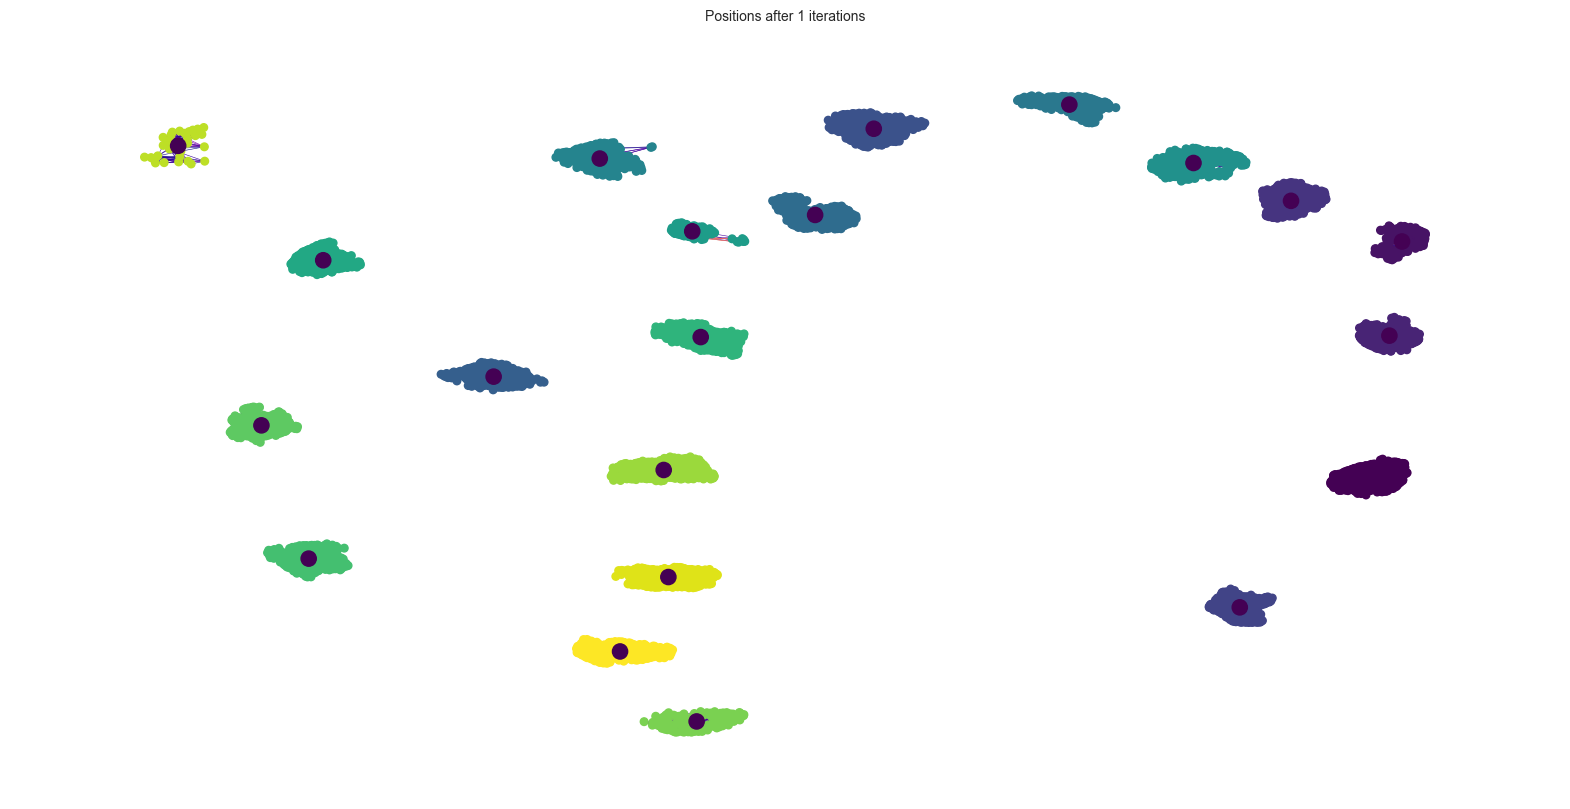

In [13]:
visualization.display_graphs([embeddings[1]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True
                             )

### 2.2 No MST, threshold at 0.1

In [14]:
embeddings_threshold, _ = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    [1, 20, 50, 100],
    threshold=0.1)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


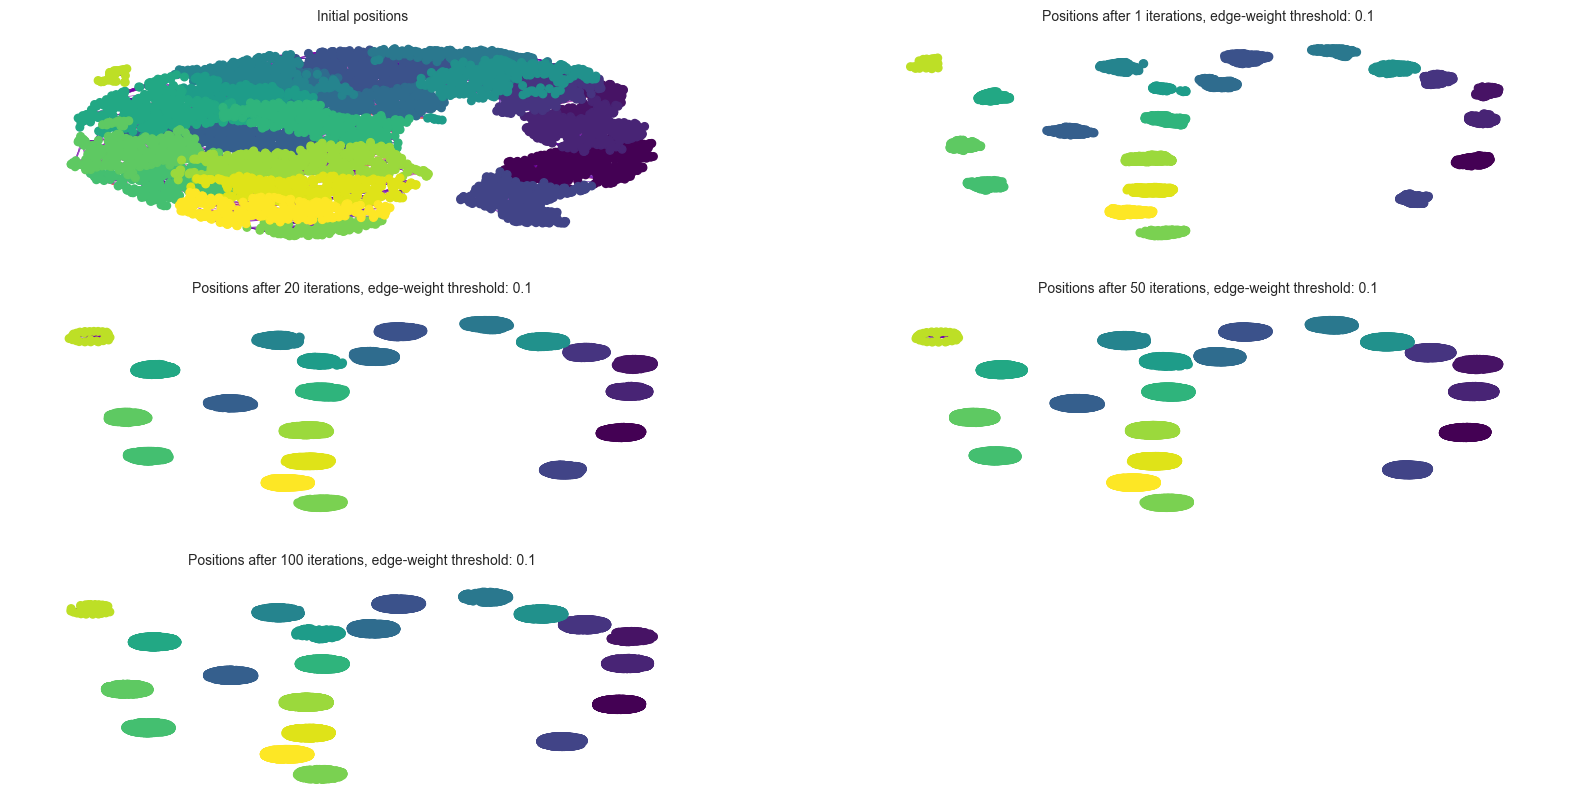

In [15]:
visualization.display_graphs(embeddings_threshold,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

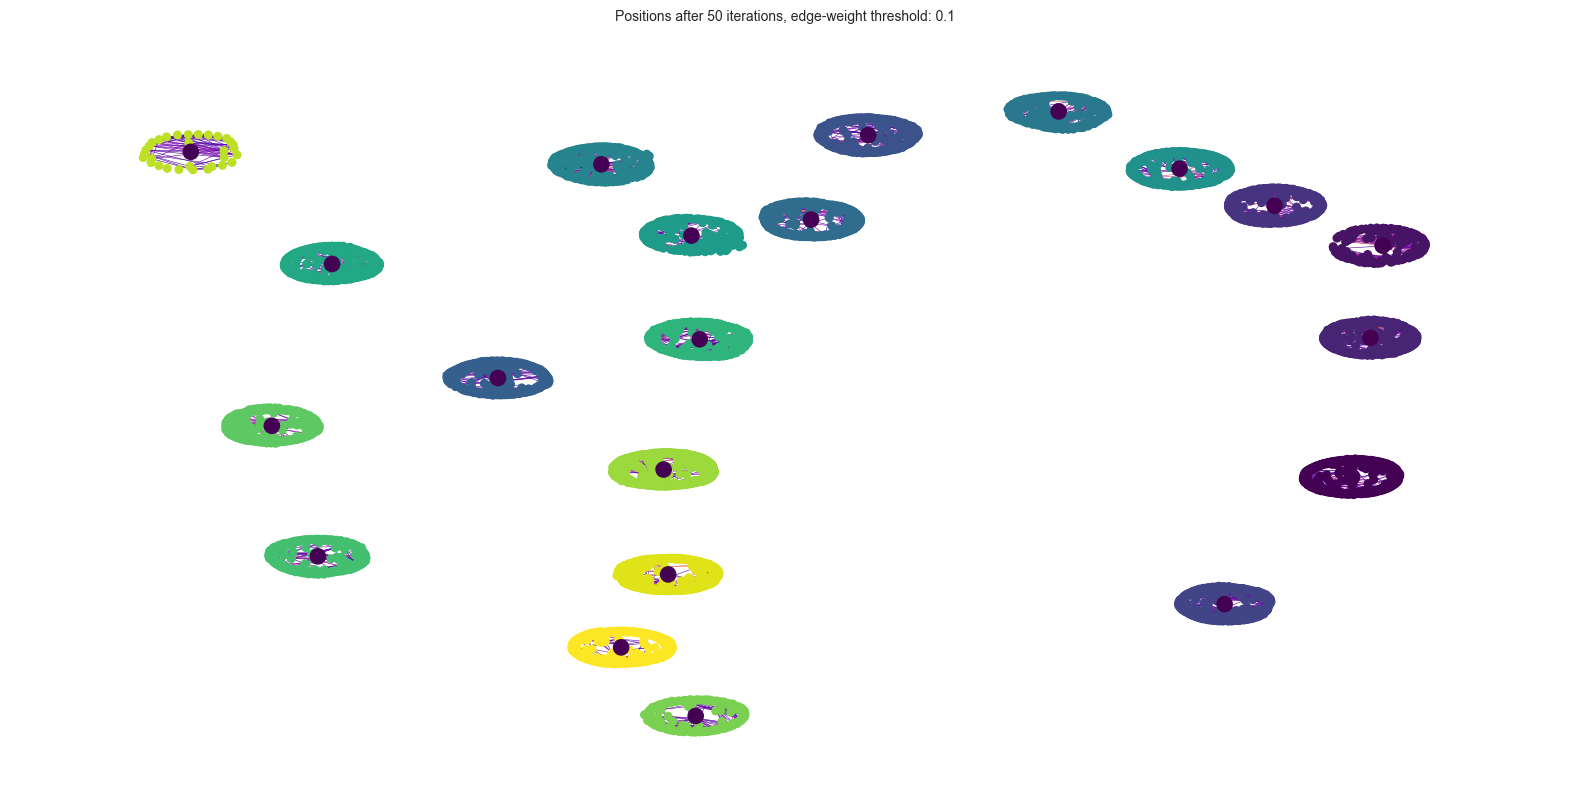

In [16]:
visualization.display_graphs([embeddings_threshold[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

### 2.3 MST, no threshold

In [17]:
embeddings_mst, _ = processing.compute_local_force_directed(connectivity_umap_knn_nx,
                                                            umap_embedding,
                                                            [1, 20, 50, 100], mst=True)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


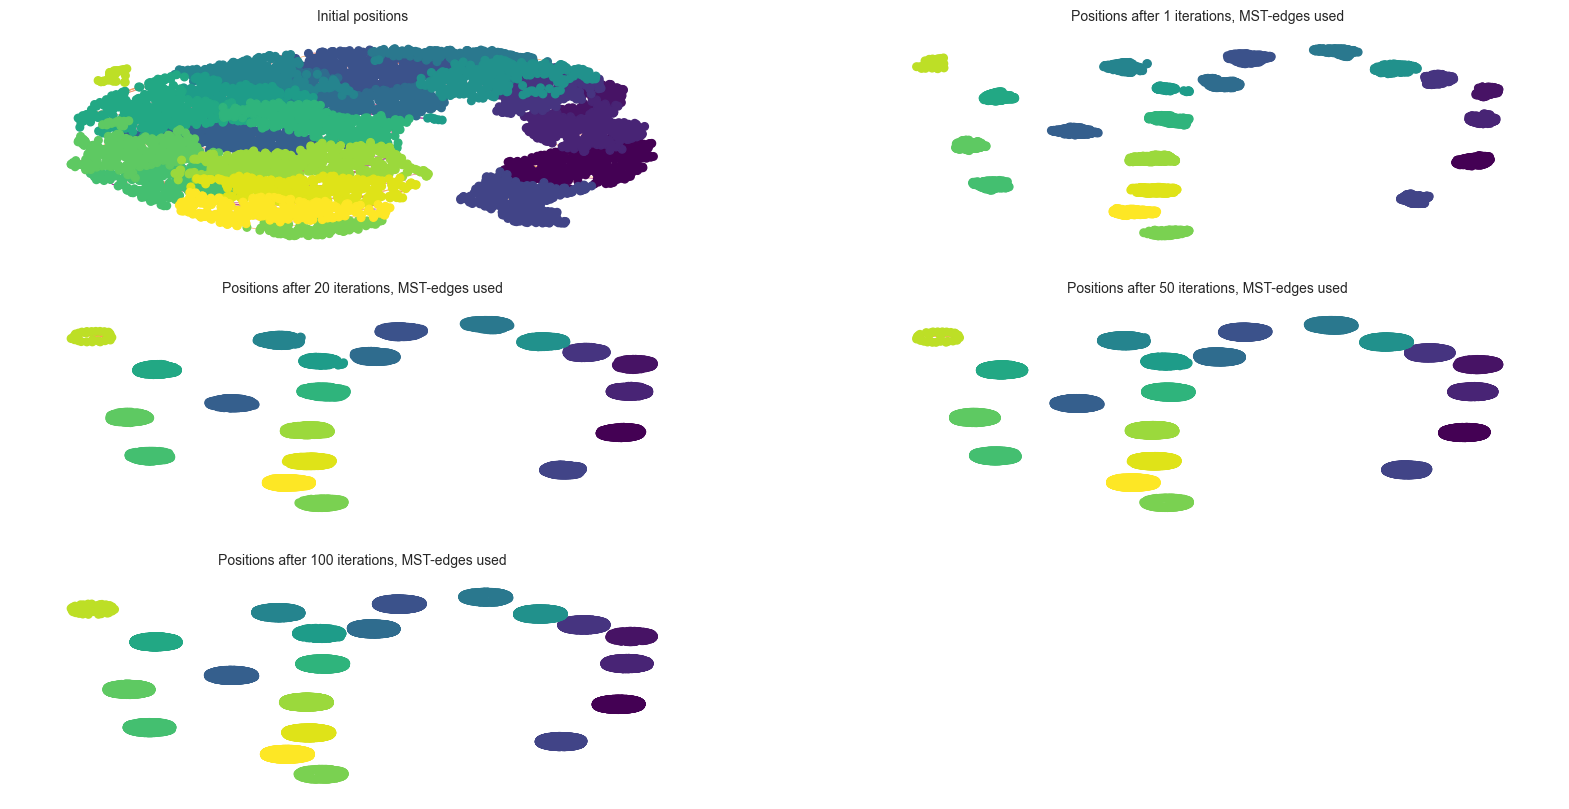

In [18]:
visualization.display_graphs(embeddings_mst,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

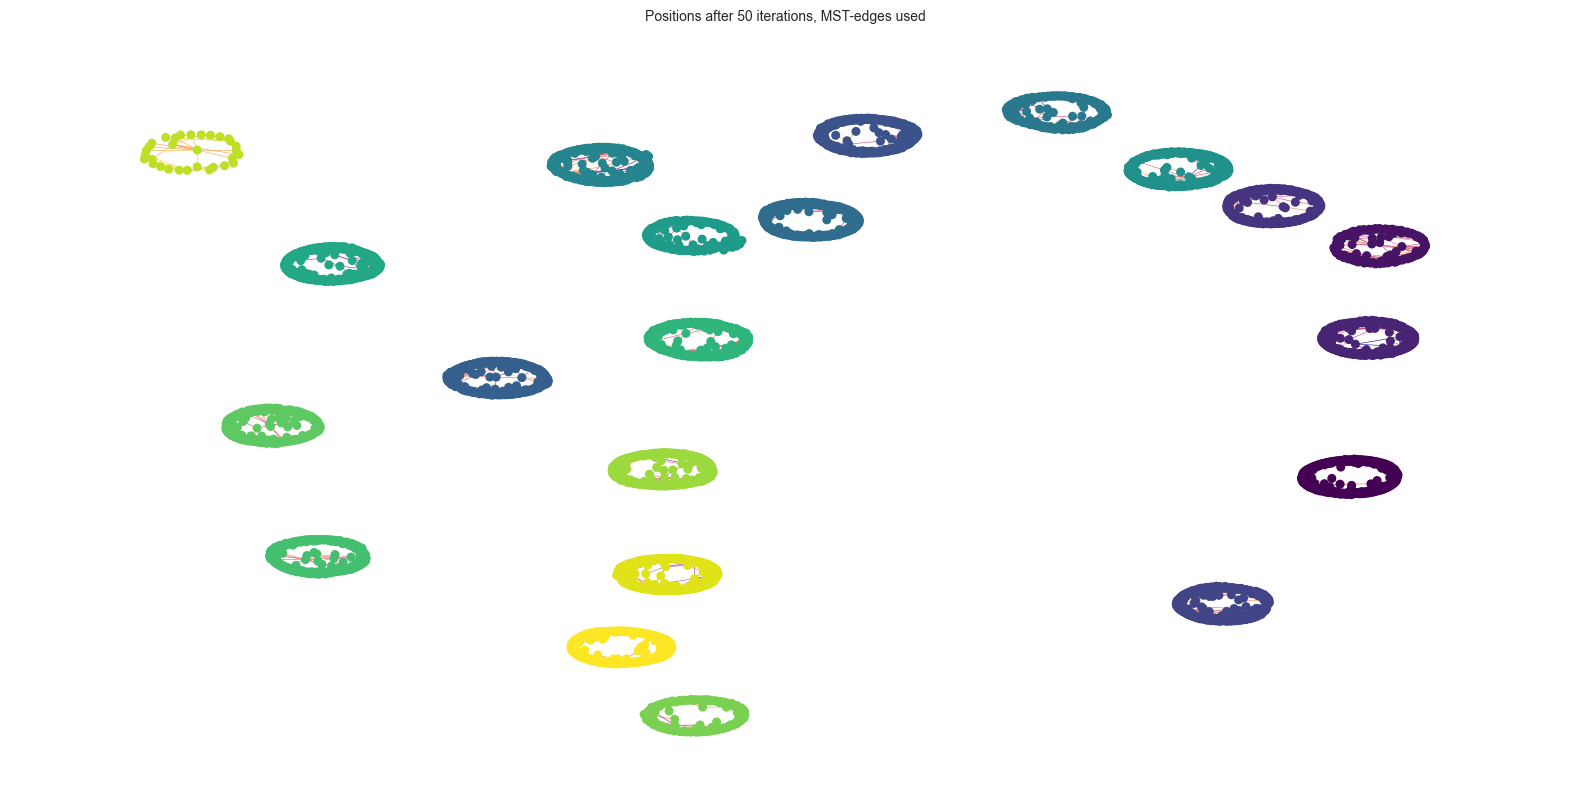

In [19]:
visualization.display_graphs([embeddings_mst[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

### 2.4 No MST, use boundary-edges

In [20]:
embeddings_boundaries, _ = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    [1, 20, 50, 100],
    boundary_edges=True)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


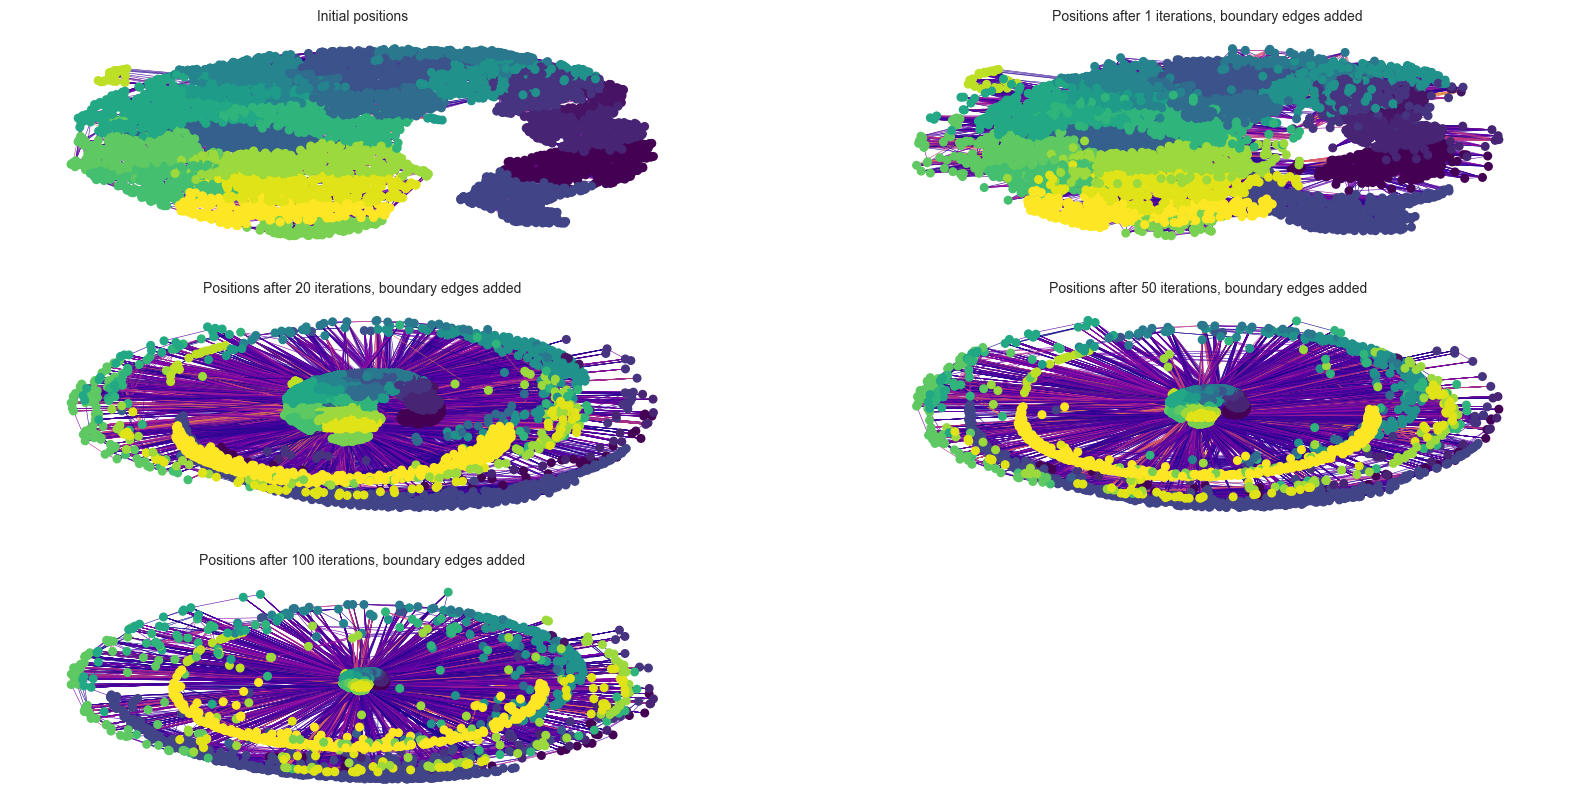

In [21]:
visualization.display_graphs(embeddings_boundaries,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=True,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

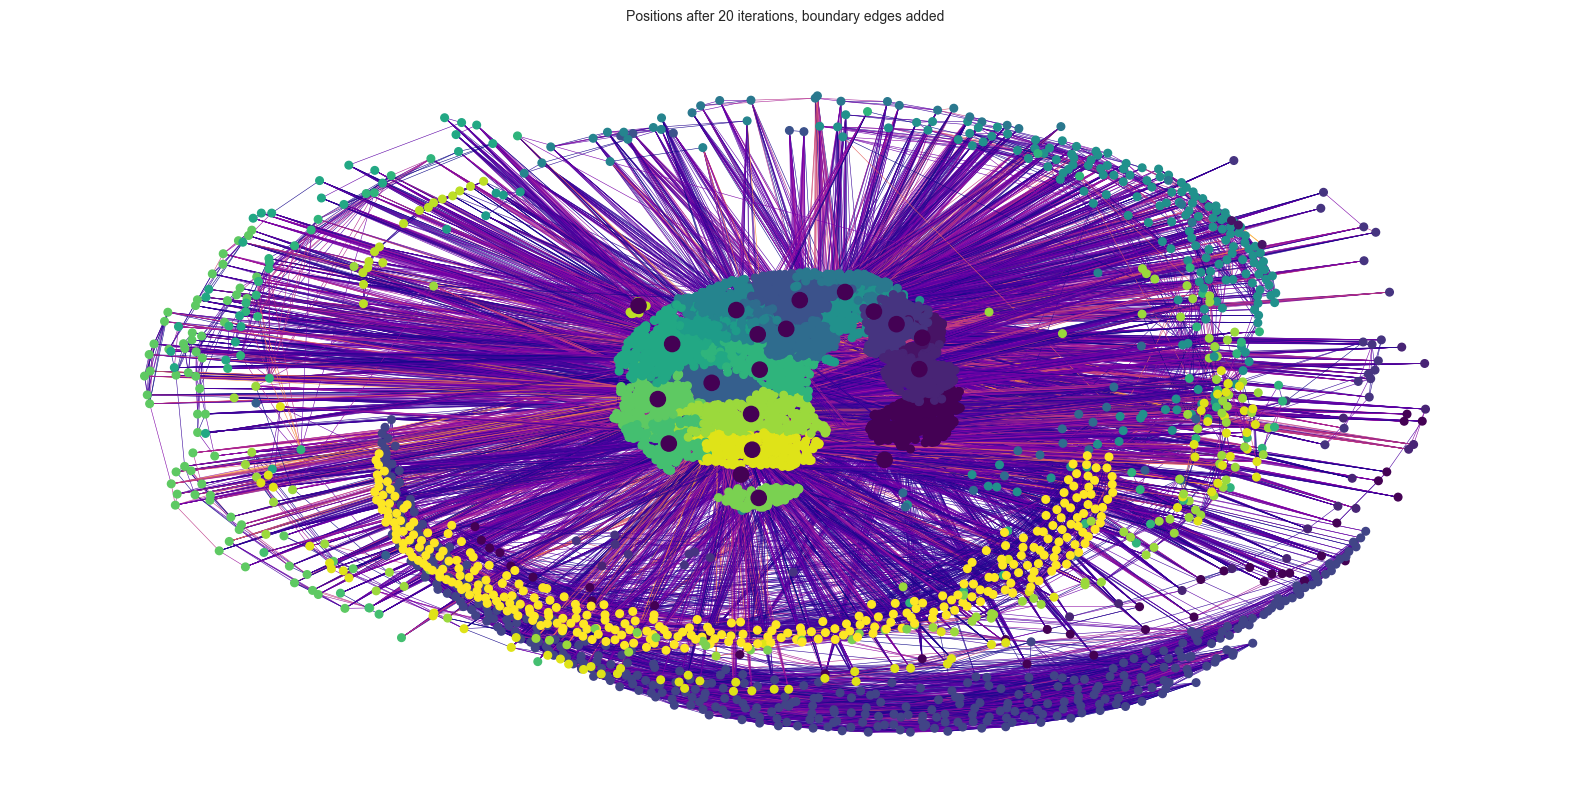

In [22]:
visualization.display_graphs([embeddings_boundaries[2]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)

### 2.5 MST, use boundary-edges

In [23]:
embeddings_mst_boundaries, _ = processing.compute_local_force_directed(
    connectivity_umap_knn_nx,
    umap_embedding,
    [1, 20, 50, 100],
    mst=True,
    boundary_edges=True)

------------------------------------------------------------
Computing modified embedding for iteration:  1
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  20
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  50
Computation finished
------------------------------------------------------------
------------------------------------------------------------
Computing modified embedding for iteration:  100
Computation finished
------------------------------------------------------------


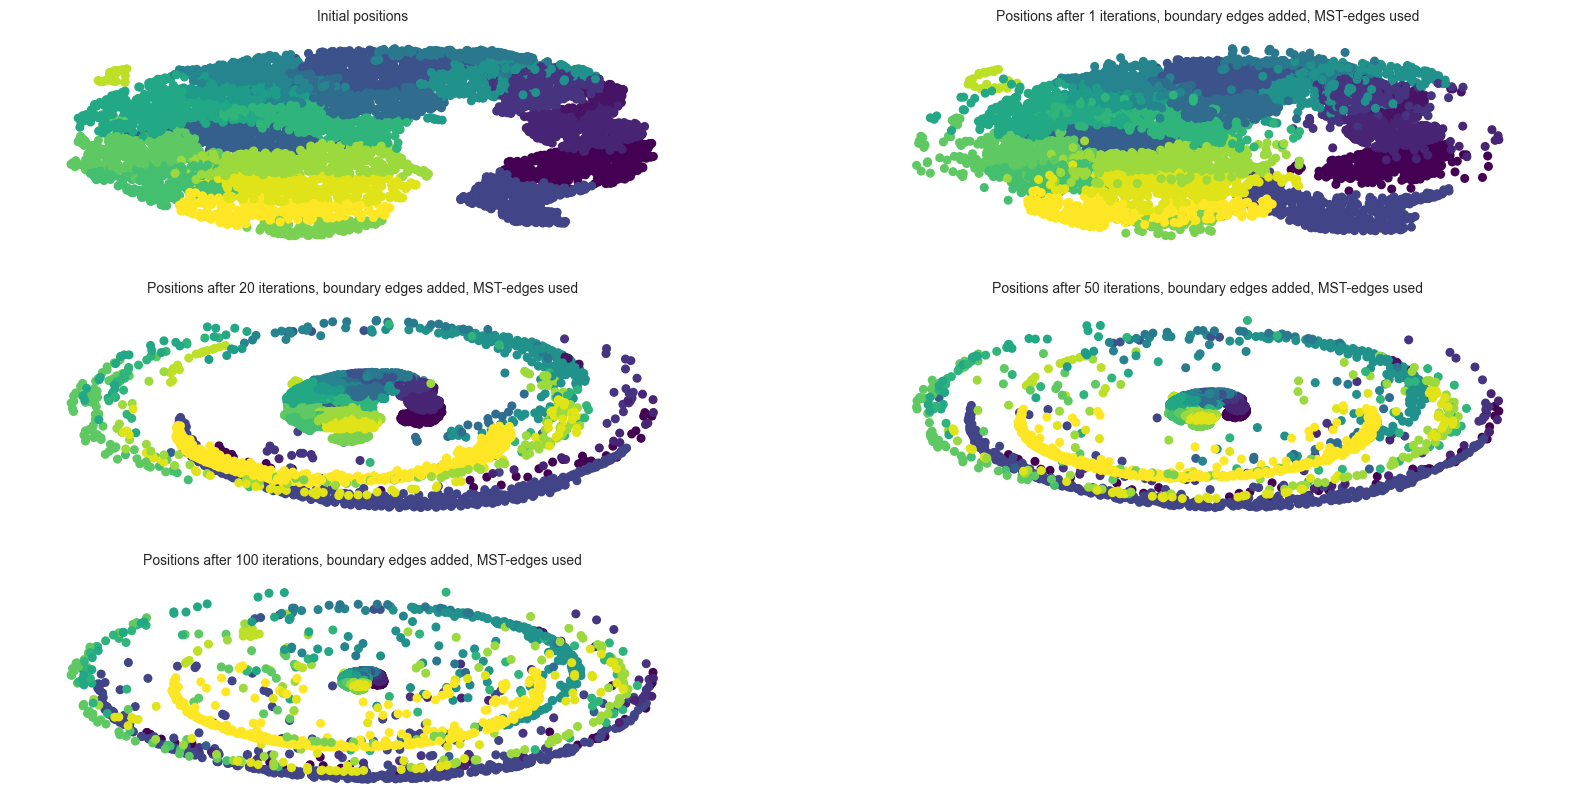

In [24]:
visualization.display_graphs(embeddings_mst_boundaries,
                             figsize_columns=2,
                             figsize=(20, 10),
                             show_edges=False,
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False)

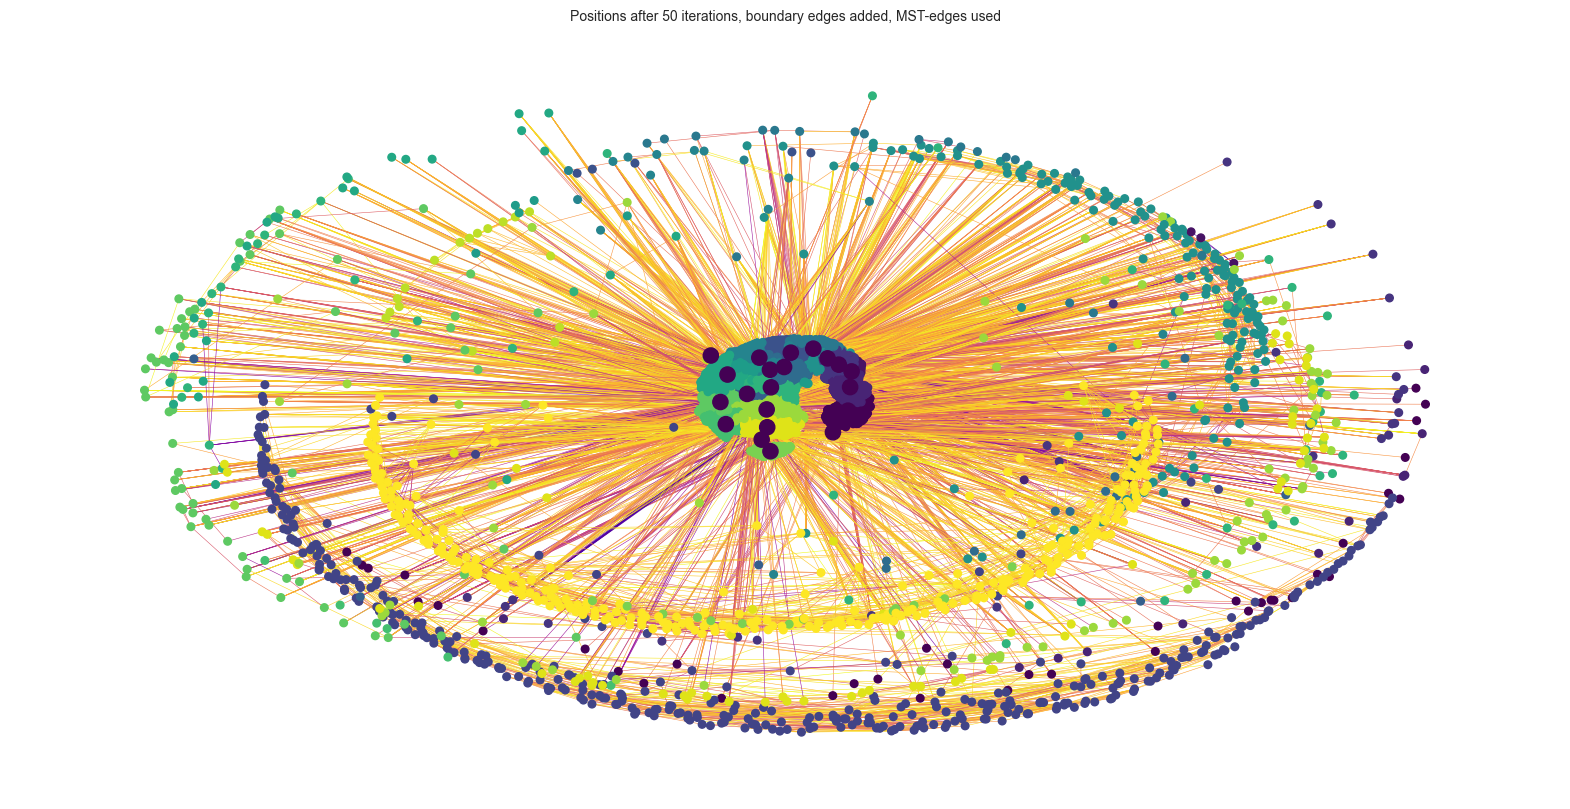

In [25]:
visualization.display_graphs([embeddings_mst_boundaries[3]],
                             figsize_columns=1,
                             figsize=(20, 10),
                             cmap='viridis',
                             cbar_labels=partition_values,
                             show_cbar=False,
                             show_partition_centers=True)